Use Random Forest to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

### Import the data

In [2]:
data = pd.read_csv("D:\\Downloads\\Prajnya\\Assignments\\14.Decision Trees\\Fraud_check.csv")
data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


### Data Preprocessing

In [3]:
data = data.rename({'Undergrad':'undergrad','Marital.Status':'marital','Taxable.Income':'taxincome','City.Population':'population','Work.Experience':'experience','Urban':'urban'},axis=1)
data.head()

,undergrad,marital,taxincome,population,experience,urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [4]:
#Creating new cols TaxInc and dividing 'Taxable.Income' cols on the basis of [10002,30000,99620] for Risky and Good
data["taxinc"] = pd.cut(data["taxincome"], bins = [10002,30000,99620], labels = ["Risky", "Good"])
data.head()

,undergrad,marital,taxincome,population,experience,urban,taxinc
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [5]:
#Creating dummy vairables for ['Undergrad','Marital.Status','Urban','taxinc'] dropping first dummy variable
data=pd.get_dummies(data,columns=['undergrad','marital','urban','taxinc'], drop_first=True)
data.head(10)

,taxincome,population,experience,undergrad_YES,marital_Married,marital_Single,urban_YES,taxinc_Good
0,68833,50047,10,0,0,1,1,1
1,33700,134075,18,1,0,0,1,1
2,36925,160205,30,0,1,0,1,1
3,50190,193264,15,1,0,1,1,1
4,81002,27533,28,0,1,0,0,1
5,33329,116382,0,0,0,0,0,1
6,83357,80890,8,0,0,0,1,1
7,62774,131253,3,1,0,1,1,1
8,83519,102481,12,0,0,1,1,1
9,98152,155482,4,1,0,0,1,1


In [6]:
data.tail(10)

,taxincome,population,experience,undergrad_YES,marital_Married,marital_Single,urban_YES,taxinc_Good
590,43018,85195,14,0,1,0,1,1
591,27394,132859,18,1,0,1,1,0
592,68152,75143,16,1,0,1,0,1
593,84775,131963,10,0,0,0,1,1
594,47364,97526,9,0,1,0,1,1
595,76340,39492,7,1,0,0,1,1
596,69967,55369,2,1,0,0,1,1
597,47334,154058,0,0,0,0,1,1
598,98592,180083,17,1,1,0,0,1
599,96519,158137,16,0,0,0,0,1


### EDA

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   taxincome        600 non-null    int64
 1   population       600 non-null    int64
 2   experience       600 non-null    int64
 3   undergrad_YES    600 non-null    uint8
 4   marital_Married  600 non-null    uint8
 5   marital_Single   600 non-null    uint8
 6   urban_YES        600 non-null    uint8
 7   taxinc_Good      600 non-null    uint8
dtypes: int64(3), uint8(5)
memory usage: 17.1 KB


In [8]:
data.isna().sum()

taxincome          0
population         0
experience         0
undergrad_YES      0
marital_Married    0
marital_Single     0
urban_YES          0
taxinc_Good        0
dtype: int64

In [10]:
data.duplicated().sum()

0

In [11]:
data.describe()

,taxincome,population,experience,undergrad_YES,marital_Married,marital_Single,urban_YES,taxinc_Good
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333,0.520000,0.323333,0.361667,0.503333,0.793333
std,26204.827597,49850.075134,8.842147,0.500017,0.468139,0.480884,0.500406,0.405252
min,10003.000000,25779.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32871.500000,66966.750000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,55074.500000,106493.500000,15.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,78611.750000,150114.250000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,99619.000000,199778.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000


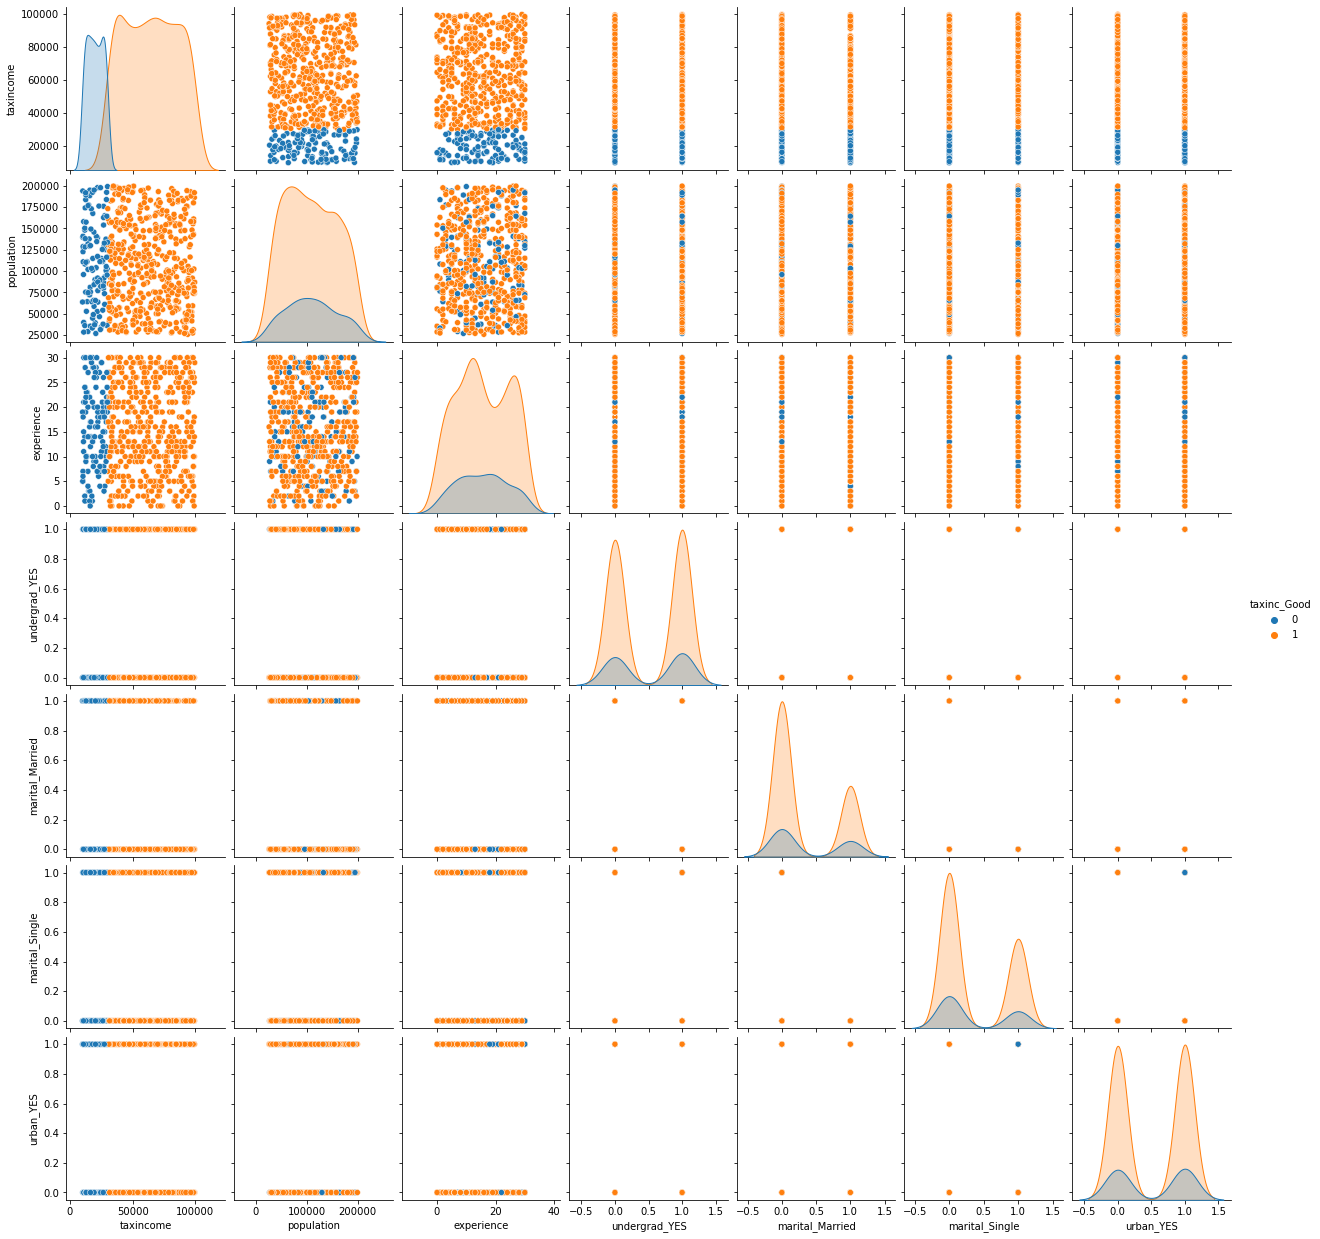

In [12]:
# pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=data, hue = 'taxinc_Good')

In [13]:
# Normalization function 
def norm_func(i):
    x = (i-i.min())/(i.max()-i.min())
    return (x)

In [14]:
# Normalized data frame (considering the numerical part of data)
data1 = norm_func(data.iloc[:,1:])
data1.head(10)

,population,experience,undergrad_YES,marital_Married,marital_Single,urban_YES,taxinc_Good
0,0.139472,0.333333,0.0,0.0,1.0,1.0,1.0
1,0.622394,0.600000,1.0,0.0,0.0,1.0,1.0
2,0.772568,1.000000,0.0,1.0,0.0,1.0,1.0
3,0.962563,0.500000,1.0,0.0,1.0,1.0,1.0
4,0.010081,0.933333,0.0,1.0,0.0,0.0,1.0
5,0.520710,0.000000,0.0,0.0,0.0,0.0,1.0
6,0.316732,0.266667,0.0,0.0,0.0,1.0,1.0
7,0.606176,0.100000,1.0,0.0,1.0,1.0,1.0
8,0.440819,0.400000,0.0,0.0,1.0,1.0,1.0
9,0.745424,0.133333,1.0,0.0,0.0,1.0,1.0


In [15]:
# Declaring features & target
x = data1.drop(['taxinc_Good'], axis=1)
y = data1['taxinc_Good']

In [16]:
x

,population,experience,undergrad_YES,marital_Married,marital_Single,urban_YES
0,0.139472,0.333333,0.0,0.0,1.0,1.0
1,0.622394,0.600000,1.0,0.0,0.0,1.0
2,0.772568,1.000000,0.0,1.0,0.0,1.0
3,0.962563,0.500000,1.0,0.0,1.0,1.0
4,0.010081,0.933333,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
595,0.078811,0.233333,1.0,0.0,0.0,1.0
596,0.170058,0.066667,1.0,0.0,0.0,1.0
597,0.737240,0.000000,0.0,0.0,0.0,1.0
598,0.886810,0.566667,1.0,1.0,0.0,0.0


In [17]:
y

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
595    1.0
596    1.0
597    1.0
598    1.0
599    1.0
Name: taxinc_Good, Length: 600, dtype: float64

In [18]:
data['taxinc_Good'].unique()

array([1, 0], dtype=uint8)

In [19]:
data.taxinc_Good.value_counts()

1    476
0    124
Name: taxinc_Good, dtype: int64

In [20]:
colnames = list(data.columns)
colnames

['taxincome',
 'population',
 'experience',
 'undergrad_YES',
 'marital_Married',
 'marital_Single',
 'urban_YES',
 'taxinc_Good']

In [21]:
# Splitting data into training and testing data set
x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.2,random_state=40)

In [22]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(480, 6) (120, 6) (480,) (120,)


### Model training using Random Forest Classifier

In [23]:
kfold = KFold(n_splits=10)

In [24]:
model = RandomForestClassifier(n_estimators=100,max_depth=3)
model.fit(x_train,y_train)

RandomForestClassifier(max_depth=3)

In [25]:
preds = model.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

1.0    120
dtype: int64

In [26]:
preds

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [27]:
pd.crosstab(y_test,preds)

col_0,1.0
taxinc_Good,
0.0,28
1.0,92


In [28]:
# Accuracy 
np.mean(preds==y_test)

0.7666666666666667

In [29]:
results = cross_val_score(model,x,y,cv=kfold)
results.mean()

0.7933333333333332

In [30]:
print(classification_report(preds,y_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.77      0.87       120

    accuracy                           0.77       120
   macro avg       0.50      0.38      0.43       120
weighted avg       1.00      0.77      0.87       120



C:\Users\prajn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prajn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
confusion_matrix(preds,y_test)

array([[ 0,  0],
       [28, 92]], dtype=int64)

In [32]:
accuracy_score(preds,y_test)

0.7666666666666667